# QBoost for QUBO

#### Device: Dirac-1


## Introduction

In addition to directly solving optimization, [quadratic unconstrained binary](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qubo-on-dirac) optimization solvers like ours have machine learning applications. The specific application we demonstrate here is one known as [boosting](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf). Particularly we are demonstrating a variant of boosting that has been adapted to quadratic solvers known as [QBoost](https://arxiv.org/pdf/0811.0416). The underlying idea of boosting is to use many sources of imperfect information to build a strong prediction. In machine learning language, we find a collection of weak classifiers that together can form a strong classifier. A weighted combination of these sources of partial information can provide a powerful tool if combined in the right way. The task that the Dirac device will be doing is to find this combination. An obvious constraint is to include the classifiers that give the most accurate information, but there is another concern. We want ones that give complementary information. Statistically speaking, we want to take classifiers that have high correlations with the information that we want to classify, but have weak correlations between them. In the extreme case, two classifiers could give the exact same information, in which case including both is wasteful. However, avoiding waste isn't the only concern here. Including too many classifiers can also lead to overfitting if they capture spurious information specific to the training data, rather than information that will generalize well to unseen cases. In this tutorial, we show an implementation of QBoost and test it on a simple binary classification problem using the IRIS dataset.


## Importance

An advantage of boosting is that once the strong classifier is built, it can be applied without having to re-solve the QUBO. As a result, the classifier can be applied in settings where access to Dirac is not available. As Dirac only gets used in the training phase, it also can be reused many times in the future. This simple application provides one example of many potential machine learning applications of our hardware.

## Applications

Classification, the task that QBoost performs, appears in a number of settings. A simple example of a classification problem that you are probably impacted by every day is email spam filtering. Here, the goal is to categorize email as "spam" or "legitimate", and it is relatively straightforward to see how the boosting approach can be applied. A variety of weak rules can be derived, (for example, a spam email is probably slightly more likely to contain the word "money"). These are of little use individually, but can be made into [a powerful filter when combined through boosting](https://arxiv.org/pdf/cs/0109015). Disease diagnosis is also fundamentally a classification problem with a concrete example being the use of boosting to [predict chronic kidney disease](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0295234). The weak classifiers would come from patient medical history, such as whether they have other conditions or not, as well as other factors such as age. Also, boosting approaches can be applied to image recognition. This is done by using simple features (for example, a nose between two eyes represented by a lighter rectangle between two darker ones) as weak classifiers, and checking for combinations of them, as was done [here for facial recognition](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf).

## Methodology

The idea is based on the concept of boosting. Let us assume that we have a collection of $N$ "weak" classifiers $h_i$ where $i=1, 2,...,N$. The goal is to construct a "strong" classifier as a linear superposition of these weak classifiers, that is,

$y = \sum_{i=1}^{N} w_i h_i({\bf{x}})$

where ${\bf{x}}$ is a vector of input features and $y \in \{-1, 1\}$. The goal is to find $w_i$, weights associated with the weak classifiers. 

Let us have a training set $\{({\bf{x_s}}, y_s) | s = 1, 2,...,S\}$ of size $S$. We can determine optimal weights $w_i$ by minimizing,

$\min_{w_i} \sum_{s=1}^{S} |\sum_{i=1}^{N} w_i h_i({\bf{x_s}}) - y_s|^2 + \lambda \sum_{i=1}^{N} (w_i)^0$

where the regularization term $\lambda \sum_{i=1}^{N} (w_i)^0$ penalizes non-zero weights; $\lambda$ is the regularization coefficient. Re-arranging the above equation yields,

$\min_{{\bf{w}}} \frac{1}{N^2} \sum_{i=1}^{N} \sum_{j=1}^{N} w_i w_j \sum_{s=1}^{S} h_i({\bf{x_s}}) h_j({\bf{x_s}}) + \frac{1}{N} \sum_{i=1}^{N} \sum_{s=1}^{S} -2 y_s h_i({\bf{x_s}}) w_i + \lambda \sum_{i=1}^{N} (w_i)^0$

where here we assume that $w_i$ weights are integers. Each weight can be constructed using $D$ qubits as

$w_i = \sum_{d=0}^{D-1} 2^d x_{i,d}$

where $x_{i,d}$ are binary variables. Navin et. al. (https://arxiv.org/abs/0811.0416) reported that using $D=1$ yields similar or improved generalized errors compared to $D > 1$. The regularization term $\lambda \sum_{i=1}^{N} (w_i)^0$ only works when $D = 1$ that is when the weights are binary. The corresponding QUBO is then,

$\min_{{\bf{x}}} {\bf{x}^T} (Q + P) {\bf{x}}$

where 

$Q_{ij} = \frac{1}{N^2} \sum_{s=1}^{S} h_i({{\bf{x_s}}}) h_j({{\bf{x_s}}})$

and

$P_{ij} = \delta_{ij} (\lambda - \frac{2}{N} \sum_{s=1}^{S} h_i({{\bf{x_s}}}) y_s)$

Note that the regularization term is designed to push many weights to zero, so a  subset of the weak classifiers are chosen.

In the implementation that follows, we have used decision tree classifiers based on one, two, or three of the features as the weak classifiers. 

## Data

We halved the IRIS dataset to build a binary classifier using QBoost. The reader can refer to 

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

and 

https://en.wikipedia.org/wiki/Iris_flower_data_set

for more information on the IRIS dataset.

## Implementation QBoost Algorithm

We have implemented the QBoost algorithm that was explained above as a class in Python.

In [1]:
from qci_client import QciClient
token = "your_token"
api_url = "https://api.qci-prod.com"
qci = QciClient(api_token=token, url=api_url)

In [2]:
# Import libs
import os
import sys
import time
import datetime
import json
from functools import wraps
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
)



PLOT_FLAG = False


def timer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        beg_time = time.time()
        val = func(*args, **kwargs)
        end_time = time.time()
        tot_time = end_time - beg_time

        print("Runtime of %s: %0.2f seconds!" % (func.__name__, tot_time,))

        return val

    return wrapper

class WeakClassifierDct:
    def __init__(self, fea_ind_list, X_train, y_train):

        assert X_train.shape[0] == len(y_train)

        self.fea_ind_list = fea_ind_list
        self.X_train = X_train
        self.y_train = y_train
        self.clf = DecisionTreeClassifier(random_state=0)

    def train(self):

        X_tmp = self.X_train.transpose()[self.fea_ind_list].transpose()

        self.clf.fit(X_tmp, self.y_train)

    def predict(self, X):

        X_tmp = X.transpose()[self.fea_ind_list].transpose()

        return self.clf.predict(X_tmp)


class QBoost:
    def __init__(
        self,
        lambda_coef,
        num_eqc_samples=10,
        alpha=1.0,
        theta=0.0,
        mode="dct",
    ):

        self.lambda_coef = lambda_coef
        self.num_eqc_samples = num_eqc_samples
        self.alpha = alpha
        self.theta = theta
        self.mode = mode
        self.weights = None
        self.h_list = None


    @timer
    def _build_weak_classifiers_dct(self, X, y):

        S = X.shape[0]
        M = X.shape[1]

        assert len(y) == S

        h_list = []

        for l in range(M):
            weak_classifier = WeakClassifierDct([l], X, y)
            weak_classifier.train()

            h_list.append(weak_classifier)

        for i in range(M):
            for j in range(i + 1, M):
                weak_classifier = WeakClassifierDct([i, j], X, y)
                weak_classifier.train()
                h_list.append(weak_classifier)

        for i in range(M):
            for j in range(i + 1, M):
                for k in range(j + 1, M):                
                    weak_classifier = WeakClassifierDct([i, j, k], X, y)
                    weak_classifier.train()
                    h_list.append(weak_classifier)
                
        return h_list
    
    
    @timer
    def _get_hamiltonian(self, X, y):

        S = X.shape[0]
        M = X.shape[1]

        if self.mode == "dct":
            h_list = self._build_weak_classifiers_dct(X, y)          
        else:
            assert False, "Incorrect mode <%s>!" % self.mode

        self.h_list = h_list

        N = len(h_list)

        Q = np.zeros(shape=(N, N), dtype="d")
        P = np.zeros(shape=(N, N), dtype="d")

        h_vals = np.array([h_list[i].predict(X) for i in range(N)])

        assert h_vals.shape[0] == N
        assert h_vals.shape[1] == S

        for i in range(N):
            P[i][i] = self.lambda_coef - (2.0 / N) * np.sum(h_vals[i] * y)
            for j in range(N):
                Q[i][j] = (1.0 / N ** 2) * np.sum(h_vals[i] * h_vals[j])

        # Calculate the Hamiltonian
        H = Q + P

        # make sure H is symmetric up to machine precision
        H = 0.5 * (H + H.transpose())

        print("The size of the hamiltonian is %d by %d" % (N, N))
        
        return H

    def set_weights(self, weights):
        self.weights = weights

    @timer
    def train(self, X, y):

        H = self._get_hamiltonian(X, y)

        N = H.shape[0]

        qubo_json = {
            "file_name": "qboost.json",
            "file_config": {
                "qubo": {"data": H, "num_variables": N},
            }  
        }
 
        job_json = {
            "job_name": "qboost_classifier",
            "job_tags": ["qboost"],
            "params": {
                "device_type": "eqc1", 
                "num_samples": self.num_eqc_samples,
                "alpha": self.alpha,
            },
        }

        # Solve the optimization problem
        #qci = QciClient()

        response_json = qci.upload_file(file=qubo_json)
        qubo_file_id = response_json["file_id"]
  
        # Setup job json
        job_params = {
            "device_type": "dirac-1", 
            "alpha": self.alpha, 
            "num_samples": self.num_eqc_samples,
        
        }
        job_json = qci.build_job_body(
            job_type="sample-qubo", 
            job_params=job_params,
            qubo_file_id=qubo_file_id,
            job_name="tutorial_eqc1",
            job_tags=["tutorial_eqc1"],
        )
        print(job_json)

        # Run the job
        job_response_json = qci.process_job(
            job_body=job_json,
        )

        print(job_response_json)

        results = job_response_json["results"]
        energies = results["energies"]
        samples = results["solutions"]
        
        if True:
            print("Energies:", energies)

        # The sample solutions are sorted by energy
        sol = samples[0]

        assert len(sol) == N, "Inconsistent solution size!"

        self.weights = np.array(sol)

        return

    def predict(self, X):

        assert self.weights is not None, "Model is not trained!"
        assert self.h_list is not None, "Model is not trained!"

        assert len(self.weights) == len(self.h_list), "Inconsisent sizes!"

        N = len(self.weights)
        tmp_vals = np.zeros(shape=(X.shape[0]), dtype="d")

        fct = sum(self.weights)
        if fct > 0:
            fct = 1.0 / fct

        for i in range(N):
            tmp_vals += self.weights[i] * self.h_list[i].predict(X)

        tmp_vals = fct * tmp_vals

        pred_vals = np.sign(tmp_vals - self.theta)

        for i in range(len(pred_vals)):
            if pred_vals[i] == 0:
                pred_vals[i] = -1.0

        return pred_vals

    def save_weights(self, file_name):
        np.save(file_name, self.weights)

The above class can then be used to build a classifier using the IRIS dataset. We have used 80\% of the data for training and the rest is used for testing.

In [3]:
import sys
from collections import Counter
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Some parameters
TEST_SIZE = 0.2
LAMBDA_COEF = 1.0

# Read dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1
    elif y[i] == 2:
        y[i] = 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42,
)

obj = QBoost(lambda_coef=LAMBDA_COEF, num_eqc_samples=10, alpha=1.0, mode="dct")

obj.train(X_train, y_train)

y_train_prd = obj.predict(X_train)
y_test_prd = obj.predict(X_test)

Runtime of _build_weak_classifiers_dct: 0.01 seconds!
The size of the hamiltonian is 14 by 14
Runtime of _get_hamiltonian: 0.01 seconds!
{'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '663bdc3698263204a3657540'}}, 'device_config': {'dirac-1': {'num_samples': 10}}, 'job_name': 'tutorial_eqc1', 'job_tags': ['tutorial_eqc1']}}
2024-05-08 13:10:30 - Dirac allocation balance = 0 s (unmetered)
2024-05-08 13:10:30 - Job submitted: job_id='663bdc36d448b017e54f94c1'
2024-05-08 13:10:30 - QUEUED
2024-05-08 13:10:33 - RUNNING
2024-05-08 13:13:26 - COMPLETED
2024-05-08 13:13:29 - Dirac allocation balance = 0 s (unmetered)
{'job_info': {'job_id': '663bdc36d448b017e54f94c1', 'job_submission': {'job_name': 'tutorial_eqc1', 'job_tags': ['tutorial_eqc1'], 'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '663bdc3698263204a3657540'}}, 'device_config': {'dirac-1': {'num_samples': 10}}}, 'job_status': {'submitted_at_r

The results show a 100\% accuracy, recall, and precision of the classifier.

Train precision: 1.0
Train recall: 1.0
Train accuracy: 1.0


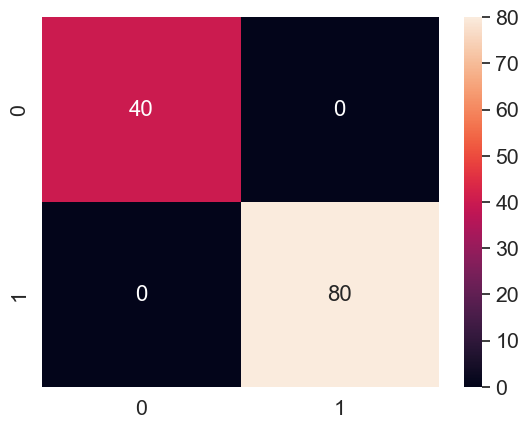

Test precision: 1.0
Test recall: 1.0
Test accuracy: 1.0


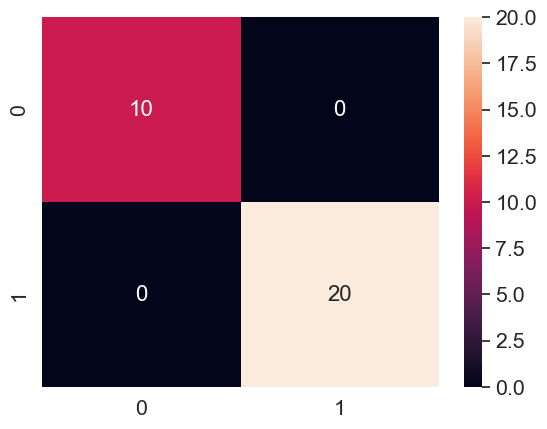

In [4]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn

print(
    "Train precision:",
    precision_score(y_train, y_train_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Train recall:",
    recall_score(y_train, y_train_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Train accuracy:",
    accuracy_score(y_train, y_train_prd),
)

sn.set(font_scale=1.4)
train_conf_mat = confusion_matrix(y_train, y_train_prd, labels=[-1, 1])
sn.heatmap(train_conf_mat, annot=True, annot_kws={"size": 16})
plt.show()

print(
    "Test precision:",
    precision_score(y_test, y_test_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Test recall:",
    recall_score(y_test, y_test_prd, labels=[-1, 1], pos_label=1),
)
print(
    "Test accuracy:",
    accuracy_score(y_test, y_test_prd),
)

test_conf_mat = confusion_matrix(y_test, y_test_prd, labels=[-1, 1])
sn.heatmap(test_conf_mat, annot=True, annot_kws={"size": 16})
plt.show()

## Conclusion

In this tutorial, we have demonstrated how to use our Dirac-1 device for a simple machine learning task with many useful applications. The methods presented here are based on the [quadratic unconstrained binary](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qubo-on-dirac) optimization formulation. You may also be interested in other machine learning applications, such as [dimensionality reduction](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/dimensionality-reduction-on-dirac), which uses the same unconstrained formulation. Alternatively, you may want to read about [feature selection](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/feature-selection-on-dirac), which uses a [quadratic linearly constrained binary](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/feature-selection-on-dirac) optimization formulation. Another option is [image classification](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/image-classicaition-on-emucore) or [audio classification](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/classification-on-emucore), which use a reservoir-based hardware offering, known as EmuCore. Of course, you may also prefer to get started trying to run a problem of your own.